# IMPORTS

In [1]:
import pandas  as pd
import numpy   as np
import inflection
import seaborn as sns
import math

from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML

## Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Loading Data

In [3]:
df_sales_raw = pd.read_csv( '../dados/train.csv', low_memory=False )
df_store_raw = pd.read_csv( '../dados/store.csv', low_memory=False )

# Merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# DESCRIÇÃO DOS DADOS

In [4]:
df1 = df_raw.copy()

## Rename Columns

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

df1.columns = cols_new

## Data Dimensions

In [8]:
print( 'Número de Linhas: {}'.format( df1.shape[0] ) )
print( 'Número de Colunas: {}'.format( df1.shape[1] ) )

Número de Linhas: 1017209
Número de Colunas: 18


## Tipo de Dados

In [9]:
df1['date'] = pd.to_datetime( df1['date'] )

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NA

**ABORDAGENS**

Ao invés de excluir as linhas com dados faltantes, o que seria uma quantidade significativa de dados, ipreencheremos os dados fantaltes considerando algumas hipóteses com base em contexto de negócio.

**competition_distance** - Se esta coluna tem NA, é porquê  (1) não tem um competidor mais próximo ou (2) o competidor está tão longe que não tem competição.
Se tivermos uma distância muito maior do que a distância máxima que tem nessa coluna, é a mesma coisa de dizer que não tem um competidor mais próximo.
O competidor mais distante está a 75860.0 metros. Abordagem: 200000.0 metros é um valor considerável para este contexto.


**competition_open_since_month** - Esta coluna mostra um mês e ano aproximado que um competidor mais próximo foi aberto. Existem duas razões para esta coluna ter NA. (1) A loja não tem um competidor mais próximo, (2) a loja tem um competidor mais próximo mas não sabemos quando ele abriu, ou porquê o competidor já existia antes da loja ser aberta ou porquê o competidor abriu depois e alguém esqueceu de registrar. Abordagem: Se *competition_open_since_month* for NA, levar a data de venda para esta coluna. "Quanto tempo faz que tem uma competição" pode ser uma boa explicação de porquê as vendas aumentam e diminuem. Não sabemos como vai funcionar, então será apenas um teste. Uma outra abordagem seria colocar nesta coluna quando for NA, a data da primeira venda da loja em questão. Dessa forma, teremos uma data estática ao longo do tempo.


**competition_open_since_year** - Mesma lógica de *competition_open_since_month*.


**promo2_since_week** - Se esta coluna tem NA, é porquê ela decidiu não participar da promoção. Abordagem: subistituir NA pela data em questão.


**promo2_since_year** - Mesma lógica de *promo2_since_week*.


**promo_interval** - São os meses que a promo2 ficou ativa. Para valores NA, significa que não tinha nenhuma promo2 ativa. Proposta: Fazer um split da coluna e, se a data estiver dentro dessa lista, significa que a venda ocorreu quando tinha uma promo2 ativa.

In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
max_value = 2000.0
print( max_value )

2000.0


In [13]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: max_value if math.isnan( x ) else x )

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

# promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

# promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo_interval
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'Mai', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec' }

df1['promo_interval'].fillna( 0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [14]:
df1.sample(5).T

,264924,535168,320209,903611,88070
store,590,754,741,132,1101
day_of_week,1,7,5,5,4
date,2014-12-01 00:00:00,2014-03-09 00:00:00,2014-10-03 00:00:00,2013-04-12 00:00:00,2015-05-14 00:00:00
sales,6585,0,0,5779,0
customers,456,0,0,508,0
open,1,0,0,1,0
promo,1,0,1,1,0
state_holiday,0,0,a,0,a
school_holiday,0,0,0,0,0
store_type,d,c,d,d,d


In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## Change Types

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## Estatística Descritiva

### Prep

In [18]:
df1['assortment'].unique()

array(['a', 'c', 'b'], dtype=object)

In [20]:
list_attributes = {
    'store': 'nominal',
    'day_of_week': 'temporal',
    'date': 'temporal',
    'sales': 'contínuo',
    'customers': 'discreto',
    'open': 'nominal',
    'promo': 'nominal',
    'state_holiday': 'nominal',
    'school_holiday': 'nominal',
    'store_type': 'ordinal',
    'assortment': 'ordinal',
    'competition_distance': 'contínuo',
    'competition_open_since_month': 'temporal',
    'competition_open_since_year': 'temporal',
    'promo2': 'nominal',
    'promo2_since_week': 'temporal',
    'promo2_since_year': 'temporal',
    'promo_interval': 'nominal',
    'month_map': 'temporal',
    'is_promo': 'nominal'
}

df_dict = pd.DataFrame( list(list_attributes.items()), columns=['attribute', 'classe'] )
df_dict

,attribute,classe
0,store,nominal
1,day_of_week,temporal
2,date,temporal
3,sales,contínuo
4,customers,discreto
5,open,nominal
6,promo,nominal
7,state_holiday,nominal
8,school_holiday,nominal
9,store_type,ordinal


In [21]:
cat_class = ['nominal', 'ordinal']
cat_dict = df_dict[df_dict.classe.isin(cat_class)]
cat_list = list(df_dict[df_dict.classe.isin(cat_class)]['attribute'])
cat_dict

,attribute,classe
0,store,nominal
5,open,nominal
6,promo,nominal
7,state_holiday,nominal
8,school_holiday,nominal
9,store_type,ordinal
10,assortment,ordinal
14,promo2,nominal
17,promo_interval,nominal
19,is_promo,nominal


In [22]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo'],
      dtype='object')

In [23]:
cat_class = ['nominal', 'ordinal']
cat_dict = df_dict[df_dict.classe.isin(cat_class)]
cat_list = list(df_dict[df_dict.classe.isin(cat_class)]['attribute'])
cat_attributes = df1[cat_list]

num_class = ['contínuo', 'discreto']
num_dict = df_dict[df_dict.classe.isin(num_class)]
num_list = list(df_dict[df_dict.classe.isin(num_class)]['attribute'])
num_attributes = df1[num_list]

temp_class = ['temporal']
temp_dict = df_dict[df_dict.classe.isin(temp_class)]
temp_list = list(df_dict[df_dict.classe.isin(temp_class)]['attribute'])
temp_attributes = df1[temp_list]

In [29]:
cat_attributes.sample(5).T

,460735,724503,157478,78850,885106
store,1026,539,264,801,582
open,1,1,1,1,1
promo,0,0,0,1,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,c,a,a,d,a
assortment,a,a,a,a,a
promo2,1,1,0,0,0
promo_interval,"Mar,Jun,Sept,Dec","Jan,Apr,Jul,Oct",0,0,0
is_promo,0,0,0,0,0


### Atributos Numéricos

In [27]:
num_attributes.sample(10).T

,344566,159376,60341,808324,311003,438674,206962,316900,360200,959483
sales,0.0,3751.0,0.0,0.0,8475.0,10243.0,3858.0,8719.0,6702.0,2770.0
customers,0.0,475.0,0.0,0.0,823.0,920.0,394.0,970.0,970.0,228.0
competition_distance,5090.0,3750.0,1040.0,1920.0,16490.0,31830.0,18760.0,270.0,140.0,330.0


In [28]:
# Tendência Central - média, mediana
m = None
tc1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
tc2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersão - desvio padrão, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

d7 = pd.DataFrame( num_attributes.apply( lambda x: x.quantile( [0.25] ).to_list()[0] ) ).T
d8 = pd.DataFrame( num_attributes.apply( lambda x: x.quantile( [0.50] ).to_list()[0] ) ).T
d9 = pd.DataFrame( num_attributes.apply( lambda x: x.quantile( [0.75] ).to_list()[0] ) ).T
d10 = pd.DataFrame( num_attributes.apply( lambda x: x.quantile( [1] ).to_list()[0] ) ).T

# Concatenação
m = pd.concat( [d2, d3, d4, tc1, tc2, d1, d5, d6, d7, d8, d9, d10] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'qtile 0.25', 'qtile 0.50', 'qtile 0.75', 'qtile 1']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis,qtile 0.25,qtile 0.50,qtile 0.75,qtile 1
0,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375,3727.0,5744.0,7856.0,41551.0
1,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773,405.0,609.0,837.0,7388.0
2,competition_distance,20.0,75860.0,75840.0,5421.176681,2320.0,7707.271425,2.933327,13.038886,710.0,2320.0,6880.0,75860.0


/tmp/ipykernel_460/4199678138.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df1['sales'] )


<Axes: xlabel='sales', ylabel='Density'>

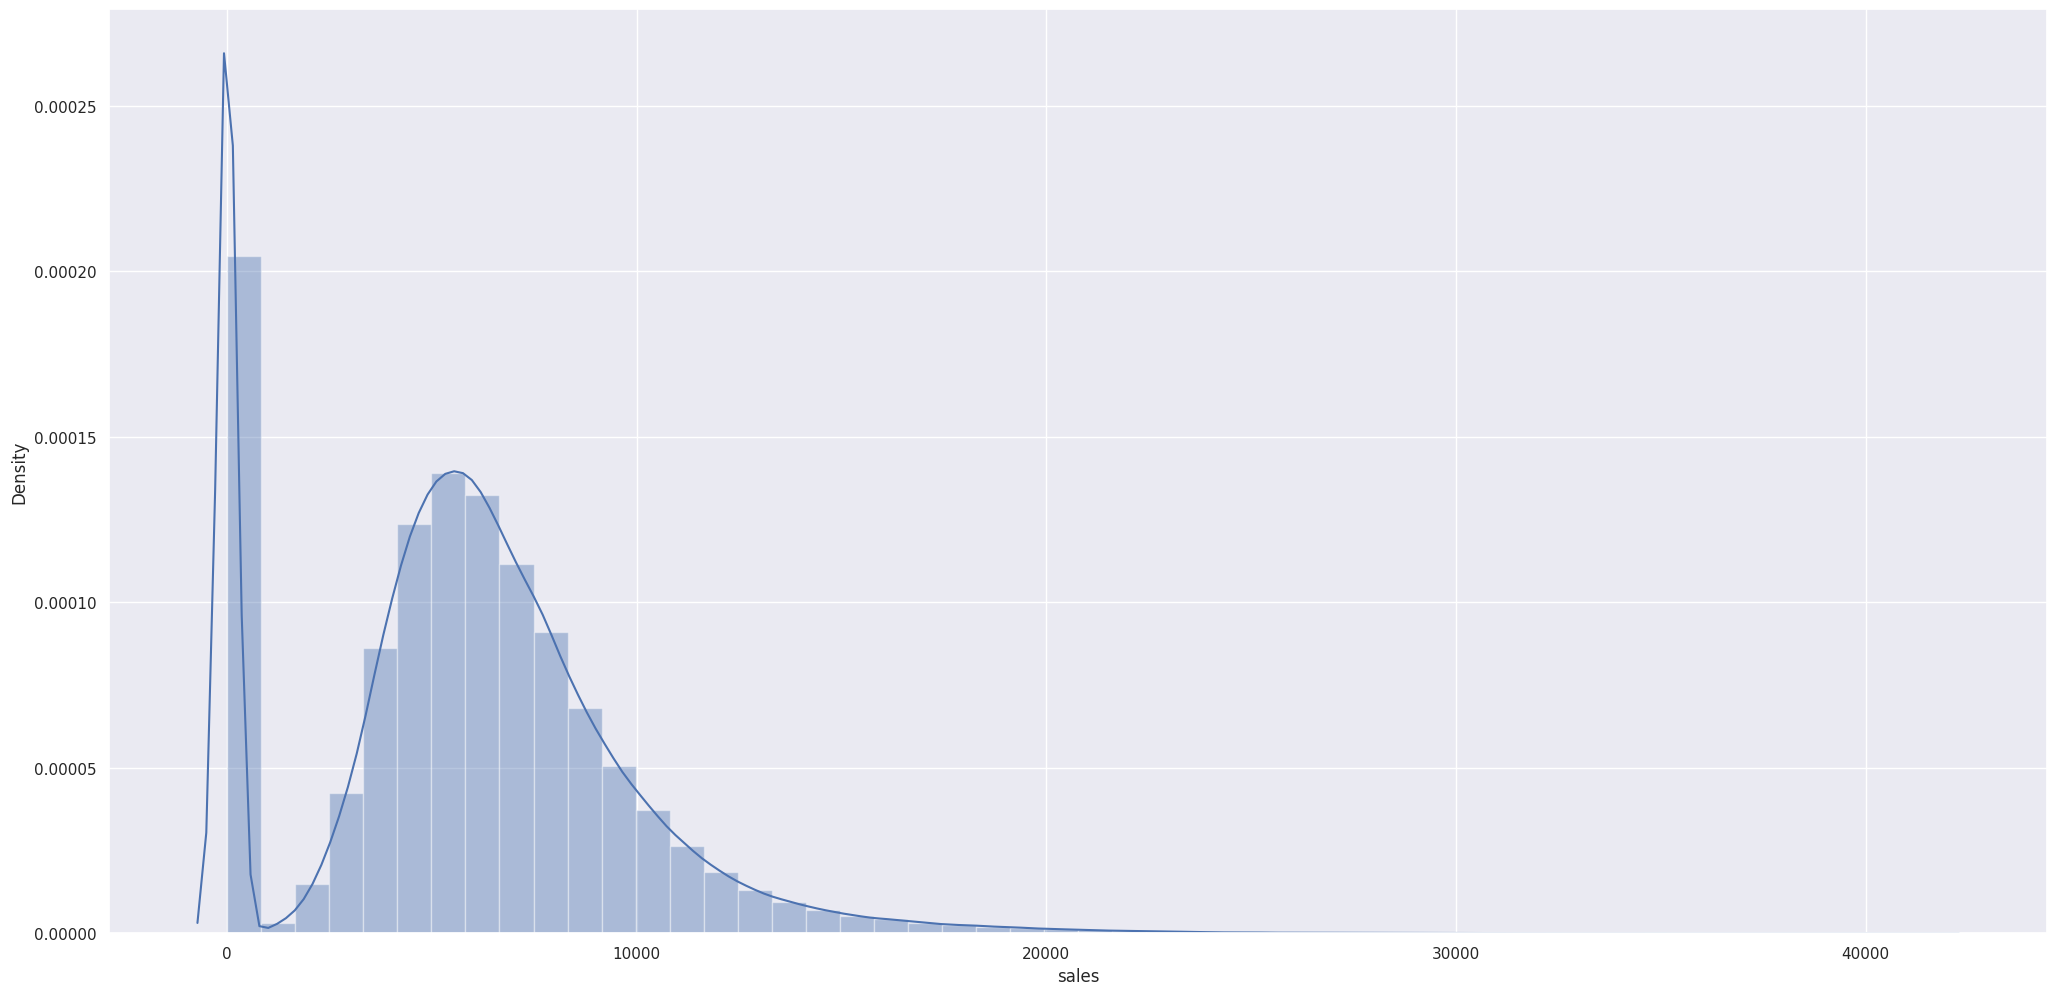

In [42]:
sns.distplot( df1['sales'] )

<Axes: xlabel='sales', ylabel='customers'>

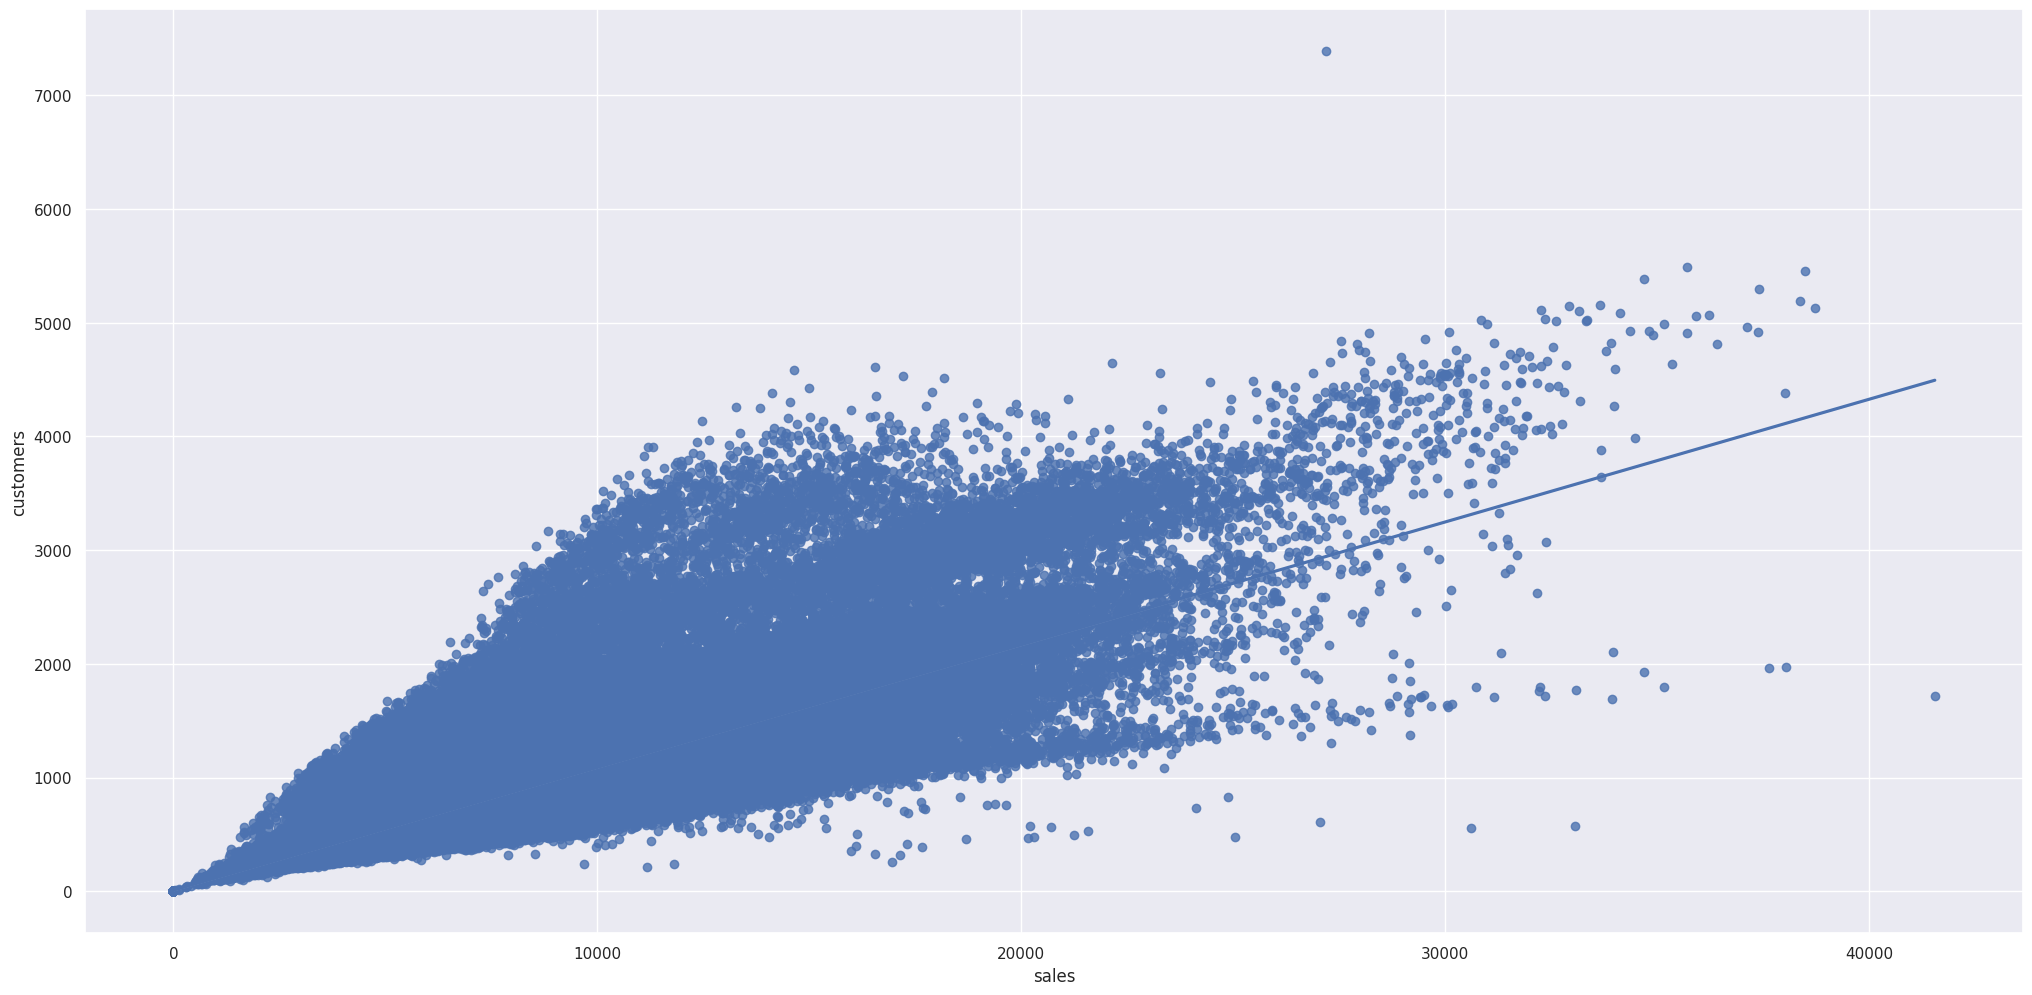

In [43]:
sns.regplot(x=df1["sales"], y=df1["customers"])

<Axes: xlabel='sales', ylabel='competition_distance'>

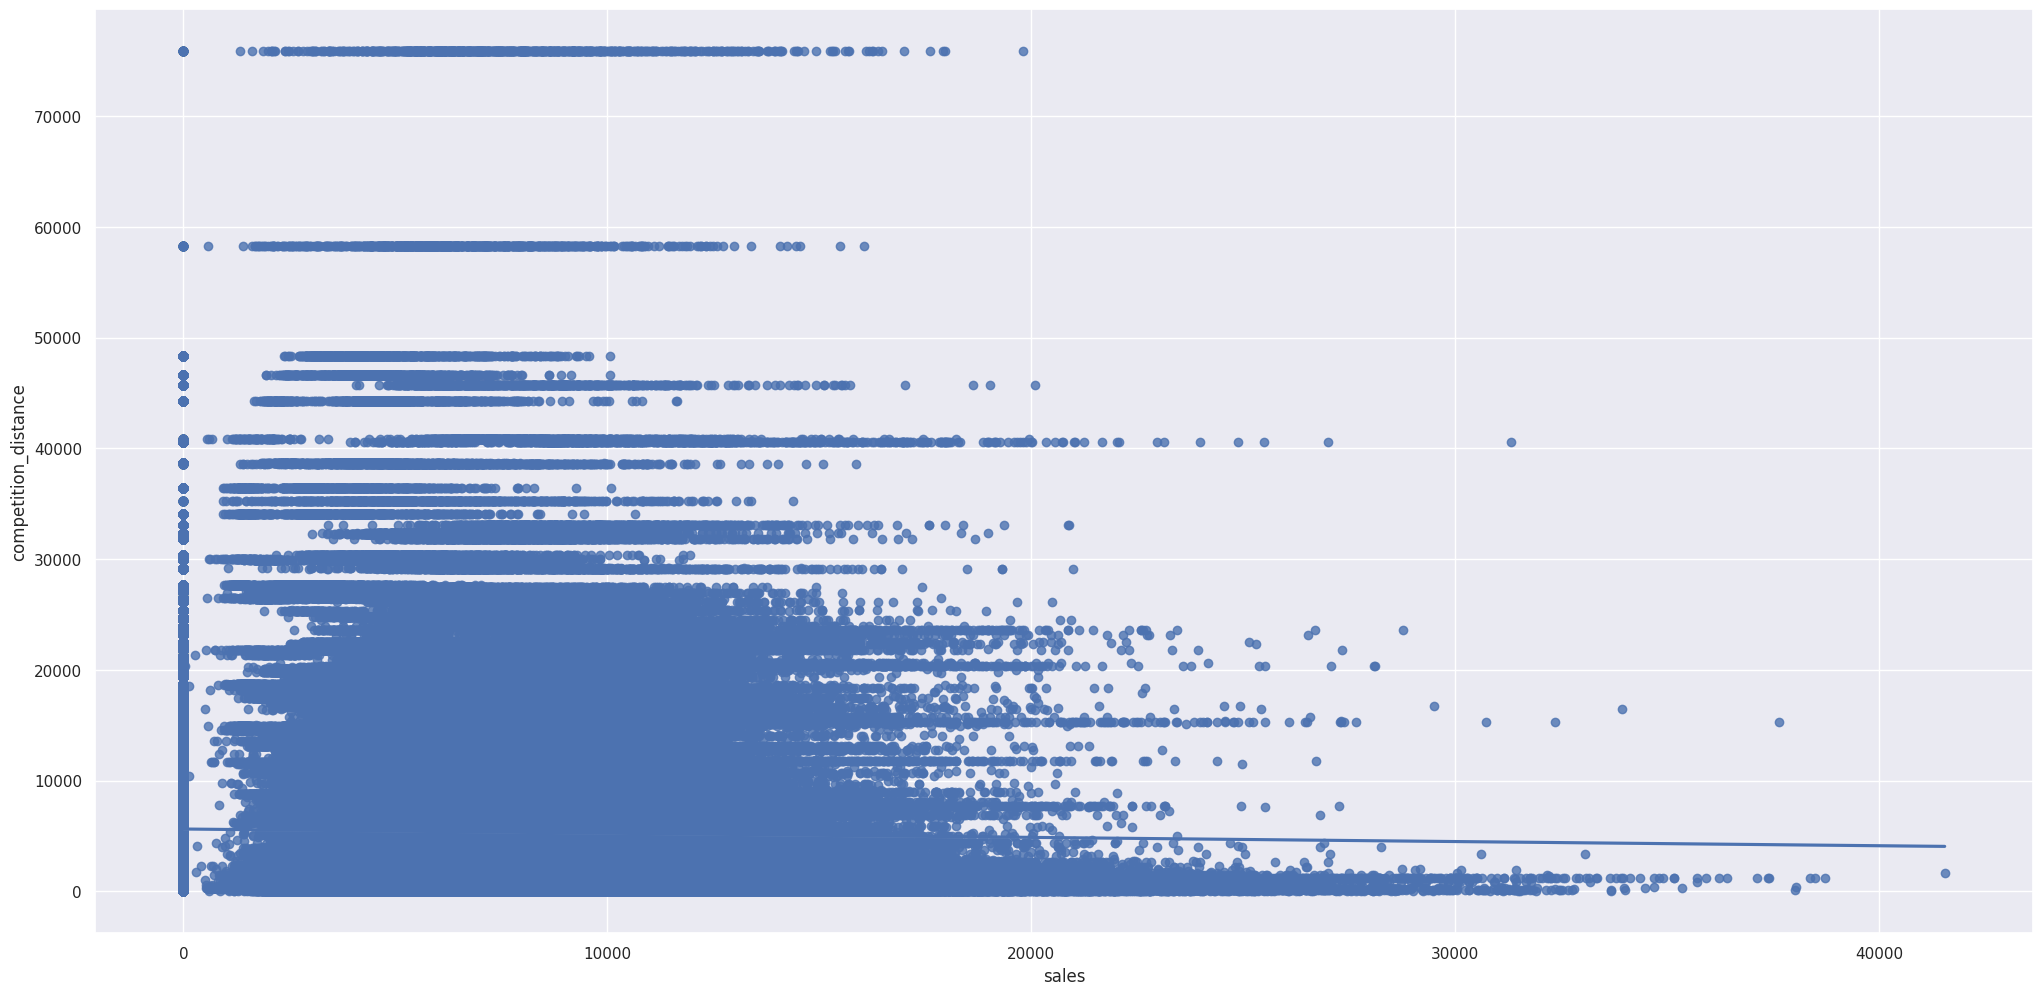

In [44]:
sns.regplot(x=df1["sales"], y=df1["competition_distance"])

### Atributos Categóricos

In [23]:
cat_attributes.sample(5).T

,1005651,266820,898649,934598,402825
store,707,622,745,1014,17
day_of_week,5,6,3,6,7
open,1,1,1,1,0
promo,1,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,a,a,a
assortment,c,c,a,c,a
competition_open_since_month,7,11,11,3,12
competition_open_since_year,1990,2014,2013,2013,2005


In [24]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

store                           1115
day_of_week                        7
open                               2
promo                              2
state_holiday                      4
school_holiday                     2
store_type                         4
assortment                         3
competition_open_since_month      12
competition_open_since_year       23
promo2                             2
promo2_since_week                 52
promo2_since_year                  7
promo_interval                     4
month_map                         12
is_promo                           2
dtype: int64

## 2